# Model Training
This notebook contains code for stage 2 of the semi-synthetic experiments: training a large corpus of models on subsets of the ELS data, whose predictions will be used as noisy estimates of student quality during the enrollment stage. 

This stage takes a significant amount of time to train all models. If you would like to use the pre-trained models, do not run this notebook and proceed to running the experiments in `experiments.ipynb`. 

In [130]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import os
import pickle
from datetime import datetime
from tqdm.notebook import trange

# for parallelism
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import multiprocessing

# for testing only
import matplotlib.pyplot as plt


# Loading Data
Here, we load the cleaned data found in the `data` folder that was generated using the code in `data_cleaning.ipynb`

In [131]:
#full_df = pd.read_csv('../data/cleaned_data.csv')
train_df = pd.read_csv('../data/no_gpa_3_cleaned_data.csv')

We use `GPA_3` as our target variable, which is an indicator that a student's first-year college GPA was greater than 3. 

The cleaned dataset contains a few additional features (sex, race, GPA, student id) that we do not use in training, but retain for demographic information in later experiments. 

The code below constructs the list of training features.

In [132]:
protected_features = ["F1SEX", "F1RACE", "F3TZYR1GPA", "id"]
outcome = "GPA_3"
# features are all the columns except protected features and outcome
features = list(train_df.columns)
for feature in protected_features:
    features.remove(feature)
features.remove(outcome)

In [133]:
train_X = train_df[features]
train_y = train_df[outcome]

# enroll_X = train_X
# enroll_y = train_y

# Training and Splitting Helper Functions

We use the following helper function to split the data into smaller training subsets. We will be training each model on a random subset of 40% of the full dataset. 

In [134]:
def get_data_subset(train_X, train_y, split_seed = None, train_size = 0.2):
    '''
    Get random subset of train_size fraction of training data.
    '''
    assert(train_size is not None)
    assert(train_size > 0 and train_size <1)
    X_subset, _, y_subset, _ = train_test_split(train_X, train_y, random_state = split_seed, train_size = train_size)
    return X_subset, y_subset

We use the following helper function to train a specified type of model on provided training sets. For each training set we perform grid-search to select good hyperparameters.

The model classes we consider are logistic regression (`log`), gradient-boosted classifier (`gb`), decision trees (`tree`), random forest (`rf`), and Xgboost (`xgb`).

The trained models are outputted after completion. 

In [135]:
def train_single_model(X, y, model = 'log', model_seed = None):
    assert(model in ['log', 'gb', 'tree', 'rf', 'xgb'])
    if model == "log":
            param_grid = {
                'C': [0.001, 0.01, 0.08, 0.1, 1.0],
                'penalty': ['l1', 'l2'],
                'max_iter': [1000]                
            }
            base_model = LogisticRegression(solver='liblinear', random_state=model_seed)
            trained_model = GridSearchCV(base_model, param_grid, cv=5)
    if model == "gb":
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7]
        }
        trained_model = GridSearchCV(GradientBoostingClassifier(random_state=model_seed), param_grid, cv=5)
    if model == "tree":
        param_grid = {
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        trained_model = GridSearchCV(DecisionTreeClassifier(random_state=model_seed), param_grid, cv=5)
    if model == "rf":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        trained_model = GridSearchCV(RandomForestClassifier(random_state=model_seed), param_grid, cv=5)
    if model == "xgb":
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5]
        }
        trained_model = GridSearchCV(XGBClassifier(random_state=model_seed), param_grid, cv=5)
    trained_model.fit(X, y)
    return trained_model
    

In [136]:
def report_model_performance(models, X_test, y_test): 
    '''
    Report the performance of each model on the test set.
    '''
    for i in range(len(models)):
        print("model score", models[i].score(X_test, y_test))
    

In [137]:
def get_estimates_from_models(models, enroll_X):
    return np.array([m.predict_proba(enroll_X)[:, 1] for m in models]).T


In [138]:
def single_train_loop(X, y, model_type, iteration_seed = None):
    models = ['gb', 'tree', 'log', 'rf', 'xgb']

    if iteration_seed is not None:
        split_seed = iteration_seed * 10
        model_seed = split_seed + model_type + 1
    else:
        model_seed = None
        split_seed = None

    x_subset, y_subset = get_data_subset(X, y, split_seed=split_seed, train_size = 0.4)
    trained_model = train_single_model(x_subset, y_subset, model = models[model_type], model_seed = model_seed)
    return (model_type, trained_model)


# Generating Splits and Training Models

In this section, we use the helper functions above to draw 200 subsets of 40% of the data and each type of model on the subset. This results in a total of 1000 models that we can use to create noisy estimates. 

Runtime: roughly 100 minutes.

In [139]:
# no parallelization
# num_its = 1

# gb_models = []
# tree_models = []
# log_models = []
# rf_models = []
# xgb_models = []

# for i in trange(num_its, desc="training iterations"):
#     x_subset, y_subset = get_data_subset(train_X, train_y, train_size = 0.4)
#     model_gb = train_single_model(x_subset, y_subset, model='gb')
#     gb_models.append(model_gb)
#     model_tree = train_single_model(x_subset, y_subset, model="tree")
#     tree_models.append(model_tree)
#     model_log = train_single_model(x_subset, y_subset, model="log")
#     log_models.append(model_log)
#     model_rf = train_single_model(x_subset, y_subset, model="rf")
#     rf_models.append(model_rf)
#     model_xgb = train_single_model(x_subset, y_subset, model="xgb")
#     xgb_models.append(model_xgb)

In [140]:
# parallel version 
all_tasks = []
models = ['gb', 'tree', 'log', 'rf', 'xgb']
num_its = 200

for i in range(num_its):
    iteration_seed = i
    for model_type in range(len(models)):

        all_tasks.append((iteration_seed, model_type))

results = Parallel(n_jobs=max(multiprocessing.cpu_count() - 1, 1))(
        delayed(single_train_loop)(train_X, train_y, model_type, iteration_seed=seed) 
        for seed, model_type in tqdm(all_tasks, desc="Training models")
    )

model_arrays = [[] for _ in range(len(models))]

for model_type, trained_model in results:
    model_arrays[model_type].append(trained_model)


Training models:   0%|          | 0/1000 [00:00<?, ?it/s]

python(98639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


# Saving Trained Models
We now save all models so that they can be loaded later to run enrollment simulations.

In [141]:
os.makedirs('saved_models', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
prefix = f'saved_models/{timestamp}_training_run'
os.makedirs(f'{prefix}')
os.makedirs(f'{prefix}/gb')
os.makedirs(f'{prefix}/tree')
os.makedirs(f'{prefix}/log')
os.makedirs(f'{prefix}/rf')
os.makedirs(f'{prefix}/xgb')

for j in range(len(model_arrays)):
    model_type = models[j]
    for i in range(len(model_arrays[0])):
        with open(f'{prefix}/{model_type}/{model_type}_model_{i}.pkl', 'wb') as f:
            pickle.dump(model_arrays[j][i], f)

# Testing

## Loading Saved Models
Checking that saved models can be properly loaded

In [95]:
def load_model(model_type, model_num, file_path):
    with open(f'{file_path}/{model_type}/{model_type}_model_{model_num}.pkl', 'rb') as f:
        return pickle.load(f)

In [97]:
file_path = 'test_runs/20250520_163131_training_run'

model_types = ['gb', 'tree', 'log', 'rf', 'xgb']

for model_type in model_types:
    print(f"Model type: {model_type}")
    for model_num in range(2):
        model = load_model(model_type, model_num, file_path)
        # print the model's score on the training data
        print(f"Model {model_num} score: {model.score(train_X, train_y)}")
        # print model estimator
        print(f"Model {model_num} estimator: {model.best_estimator_}")

Model type: gb
Model 0 score: 0.7492029755579172
Model 0 estimator: GradientBoostingClassifier(random_state=1)
Model 1 score: 0.7372476089266737
Model 1 estimator: GradientBoostingClassifier(learning_rate=0.01, n_estimators=200,
                           random_state=11)
Model type: tree
Model 0 score: 0.7328639744952179
Model 0 estimator: DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=2)
Model 1 score: 0.7324654622741764
Model 1 estimator: DecisionTreeClassifier(max_depth=3, random_state=12)
Model type: log
Model 0 score: 0.7418969181721573
Model 0 estimator: LogisticRegression(C=0.1, max_iter=1000, random_state=3, solver='liblinear')
Model 1 score: 0.7357863974495218
Model 1 estimator: LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=13,
                   solver='liblinear')
Model type: rf
Model 0 score: 0.7440223166843783
Model 0 estimator: RandomForestClassifier(max_depth=7, min_samples_split=5, random_state=4)
Model 1 score: 0.73804463336

## Replication
Ensuring that random seeds ensure the same models each time.

In [100]:
file_path_1 = 'test_runs/20250520_163131_training_run'
file_path_2 = 'test_runs/20250520_163310_training_run'

model_types = ['gb', 'tree', 'log', 'rf', 'xgb']

for model_type in model_types:
    print(f"Model type: {model_type}")
    for model_num in range(2):
        model_1 = load_model(model_type, model_num, file_path_1)
        model_2 = load_model(model_type, model_num, file_path_2)
        print(f"Model {model_num} {model_type} score, run 1: {model_1.score(train_X, train_y)}")
        print(f"Model {model_num} {model_type} score, run 2: {model_2.score(train_X, train_y)}")
        model_1_probs = model_1.predict_proba(train_X)
        model_2_probs = model_2.predict_proba(train_X)
        assert(np.array_equal(model_1_probs, model_2_probs))

print("Equality checks passed")

Model type: gb
Model 0 gb score, run 1: 0.7492029755579172
Model 0 gb score, run 2: 0.7492029755579172
Model 1 gb score, run 1: 0.7372476089266737
Model 1 gb score, run 2: 0.7372476089266737
Model type: tree
Model 0 tree score, run 1: 0.7328639744952179
Model 0 tree score, run 2: 0.7328639744952179
Model 1 tree score, run 1: 0.7324654622741764
Model 1 tree score, run 2: 0.7324654622741764
Model type: log
Model 0 log score, run 1: 0.7418969181721573
Model 0 log score, run 2: 0.7418969181721573
Model 1 log score, run 1: 0.7357863974495218
Model 1 log score, run 2: 0.7357863974495218
Model type: rf
Model 0 rf score, run 1: 0.7440223166843783
Model 0 rf score, run 2: 0.7440223166843783
Model 1 rf score, run 1: 0.7380446333687567
Model 1 rf score, run 2: 0.7380446333687567
Model type: xgb
Model 0 xgb score, run 1: 0.744287991498406
Model 0 xgb score, run 2: 0.744287991498406
Model 1 xgb score, run 1: 0.7505313496280552
Model 1 xgb score, run 2: 0.7505313496280552
Equality checks passed


## Performance Details
Getting data on the performance of the pretrained models

### Thresholded Accuracy
In our simulations, schools will accept students based on a model's predicted quality. Thus, it's helpful to understand the model performance when thresholded at various predicted values. 

In [146]:
file_path = 'pretrained_models'
model_types = ['gb', 'tree', 'log', 'rf', 'xgb']
num_models = 200

thresholds = np.arange(0.01, 0.85, 0.01)
accuracies = np.zeros((len(model_types), len(thresholds), num_models))

for model_type in range(len(model_types)):
    for model_num in range(num_models):
        model = load_model(model_types[model_type], model_num, file_path)
        model_probs = model.predict_proba(train_X)
        for t in range(len(thresholds)):
            threshold = thresholds[t]
            above_t = np.where(model_probs[:, 1] > threshold)[0]
            acc = np.mean(train_y[above_t])
            accuracies[model_type][t][model_num] = acc


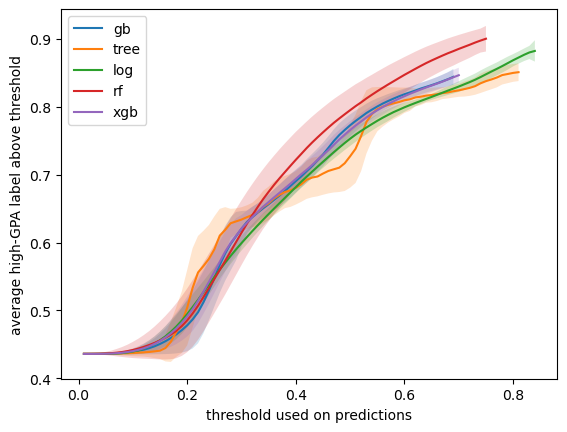

In [147]:
threshold_means = np.mean(accuracies, axis = 2)
threshold_stds = np.std(accuracies, axis = 2)

for i in range(len(model_types)):
    plt.plot(thresholds,  threshold_means[i], label=model_types[i])
    plt.fill_between(thresholds, threshold_means[i] - threshold_stds[i], threshold_means[i] + threshold_stds[i], alpha=0.2)
plt.legend()
plt.xlabel("threshold used on predictions")
plt.ylabel("average high-GPA label above threshold")
plt.show()

